In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import os
import re
import datetime
from datetime import date
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from IPython.display import display

import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
#!pip install --quiet ckiptagger
#from ckiptagger import data_utils, construct_dictionary, WS
#data_utils.download_data_gdown("./")
#ws = WS("./data", disable_cuda=False)

In [3]:
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.font_manager import fontManager

# 改style要在改font之前
# plt.style.use('seaborn')

fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
mpl.rc('font', family='Taipei Sans TC Beta')

--2024-01-10 02:53:36--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 108.177.121.102, 108.177.121.113, 108.177.121.139, ...
Connecting to drive.google.com (drive.google.com)|108.177.121.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/e5f0mmsu7bun4du65akflrihdnudvsps/1704855150000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_?uuid=f7e67579-90f5-4ae3-8256-512e185072fc [following]
--2024-01-10 02:53:37--  https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/e5f0mmsu7bun4du65akflrihdnudvsps/1704855150000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_?uuid=f7e67579-90f5-4ae3-8256-512e185072fc
Resolving doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)... 173.194.193.132, 2607:f8b0:4001:c0f::84
Connecting to d

In [4]:
monthly_data = {}
male_clothing = {}
female_clothing = {}
for month in range(1, 13):
  # 格式化字串，生成檔案路徑
  file_path = f"/content/drive/MyDrive/Colab Notebooks/文字探勘期末/{month:02d}.csv"

  # 讀取檔案並將資料存入字典
  monthly_data[f"{month:02d}"] = pd.read_csv(file_path)
  # 直接去除NA值(商品名稱為空)
  monthly_data[f"{month:02d}"].dropna(inplace = True)
  monthly_data[f"{month:02d}"] = monthly_data[f"{month:02d}"].iloc[:,1:11]
  monthly_data[f"{month:02d}"]['time'] = pd.to_datetime(monthly_data[f"{month:02d}"]['time'].apply(lambda x: x[:10]))

  # 新增 '男生衣著' 和 '女生衣著' 兩個新欄位
  monthly_data[f"{month:02d}"]['男生衣著'] = (
      monthly_data[f"{month:02d}"]['new_Category'] == '男生衣著'
  )
  monthly_data[f"{month:02d}"]['女生衣著'] = (
      monthly_data[f"{month:02d}"]['new_Category'] == '女生衣著'
  )

  # 將 '男生衣著' 和 '女生衣著' 的資料分別存入字典
  male_clothing_data = monthly_data[f"{month:02d}"][monthly_data[f"{month:02d}"]['男生衣著']]
  female_clothing_data = monthly_data[f"{month:02d}"][monthly_data[f"{month:02d}"]['女生衣著']]

  male_clothing[f"{month:02d}"] = male_clothing_data
  female_clothing[f"{month:02d}"] = female_clothing_data

  monthly_data[f"{month:02d}"] = monthly_data[f"{month:02d}"].drop(['男生衣著', '女生衣著'], axis = 1)
  male_clothing[f"{month:02d}"] = male_clothing[f"{month:02d}"].drop(['男生衣著', '女生衣著'], axis = 1)
  female_clothing[f"{month:02d}"] = female_clothing[f"{month:02d}"].drop(['男生衣著', '女生衣著'], axis = 1)

# 男生

In [5]:
male_data = pd.DataFrame()
# 將男性各月份連接成一個大資料集
for month in range(1, 13):
  male_data = pd.concat([male_data, male_clothing[f"{month:02d}"]], ignore_index=True)
# 按時間排序
male_data.sort_values(by=['time'], inplace=True)
# 將2021-12-31的資料整理至2022-1-1
male_data.loc[male_data['time'] == date(2021, 12, 31), 'time'] = date(2022, 1, 1)
male_data['time'] = pd.to_datetime(male_data['time'])
male_data.reset_index(drop=True, inplace=True)
# 只取價格大於等於0的資料
male_data = male_data[male_data['price'] >= 0]

In [6]:
len(male_data['SubCategory'].unique())

18

# 商品名稱 x 總銷量

In [7]:
male_data

,id,time,commodity_id,category,ProductName,total_quantity,price,total_amount,new_Category,SubCategory
0,4074676,2022-01-01,5836340,['女生衣著'],第022標XL綠色外套,1,39,39,男生衣著,外套
1,4062138,2022-01-01,5835515,['女生衣著'],第025標尚1918神褲!!超級百搭,11,285,3135,男生衣著,長褲
2,4061860,2022-01-01,5835358,['女生衣著'],第055標上衣2,1,150,150,男生衣著,T恤
3,4061847,2022-01-01,5835351,['男生衣著'],"58CKJEANS特殊款""中性款""帽踢15881帶尺寸",10,1588,15880,男生衣著,帽T
4,4061630,2022-01-01,5835239,['男生衣著'],"55海鷗超爆款手袖電繡logo""男款""薄長T10001帶尺寸",20,1000,20000,男生衣著,T恤
...,...,...,...,...,...,...,...,...,...,...
232953,21424209,2022-12-31,10720082,['女生衣著'],第031標兩件上衣,1,50,50,男生衣著,T恤
232954,21424267,2022-12-31,10720096,['女生衣著'],2790設計師背心,1,400,400,男生衣著,坦克
232955,21424288,2022-12-31,10720103,['女生衣著'],2791灰色豹紋上衣,1,350,350,男生衣著,T恤
232956,21423164,2022-12-31,10719751,['男生衣著'],2766M號牛仔短褲,1,230,230,男生衣著,短褲


## 定義特價關鍵字

In [17]:
def get_ws(df):
  tmp_word_df = df.assign(word = ws(list(df["ProductName"])))
  return tmp_word_df

In [19]:
ws_df = get_ws(male_data)

Exception ignored in: <function WS.__del__ at 0x7907979cf130>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ckiptagger/api.py", line 65, in __del__
    self.model.sess.close()
AttributeError: 'WS' object has no attribute 'model'


In [20]:
ws_df

,id,time,commodity_id,category,ProductName,total_quantity,price,total_amount,new_Category,SubCategory,Special,word
0,4074676,2022-01-01,5836340,['女生衣著'],第022標XL綠色外套,1,39,39,男生衣著,外套,False,"[第022, 標, XL, 綠色, 外套]"
1,4062138,2022-01-01,5835515,['女生衣著'],第025標尚1918神褲!!超級百搭,11,285,3135,男生衣著,長褲,False,"[第025, 標, 尚, 1918, 神褲, !, !, 超級, 百搭]"
2,4061860,2022-01-01,5835358,['女生衣著'],第055標上衣2,1,150,150,男生衣著,T恤,False,"[第055, 標, 上衣, 2]"
3,4061847,2022-01-01,5835351,['男生衣著'],"58CKJEANS特殊款""中性款""帽踢15881帶尺寸",10,1588,15880,男生衣著,帽T,False,"[58, CKJEANS, 特殊款, "", 中性款, "", 帽, 踢, 15881, 帶, 尺寸]"
4,4061630,2022-01-01,5835239,['男生衣著'],"55海鷗超爆款手袖電繡logo""男款""薄長T10001帶尺寸",20,1000,20000,男生衣著,T恤,False,"[55, 海鷗, 超爆款, 手袖, 電繡, logo"", 男款, "", 薄長, T10001..."
...,...,...,...,...,...,...,...,...,...,...,...,...
232953,21424209,2022-12-31,10720082,['女生衣著'],第031標兩件上衣,1,50,50,男生衣著,T恤,False,"[第031, 標, 兩, 件, 上衣]"
232954,21424267,2022-12-31,10720096,['女生衣著'],2790設計師背心,1,400,400,男生衣著,坦克,False,"[2790, 設計師, 背心]"
232955,21424288,2022-12-31,10720103,['女生衣著'],2791灰色豹紋上衣,1,350,350,男生衣著,T恤,False,"[2791, 灰色, 豹紋, 上衣]"
232956,21423164,2022-12-31,10719751,['男生衣著'],2766M號牛仔短褲,1,230,230,男生衣著,短褲,False,"[2766, M號, 牛仔, 短褲]"


In [23]:
ws2_df = ws_df.explode("word")
# 只保留長度大於1的詞
ws2_df = ws2_df.loc[ws2_df['word'].str.len()>1]

In [24]:
ws2_df

,id,time,commodity_id,category,ProductName,total_quantity,price,total_amount,new_Category,SubCategory,Special,word
0,4074676,2022-01-01,5836340,['女生衣著'],第022標XL綠色外套,1,39,39,男生衣著,外套,False,第022
0,4074676,2022-01-01,5836340,['女生衣著'],第022標XL綠色外套,1,39,39,男生衣著,外套,False,XL
0,4074676,2022-01-01,5836340,['女生衣著'],第022標XL綠色外套,1,39,39,男生衣著,外套,False,綠色
0,4074676,2022-01-01,5836340,['女生衣著'],第022標XL綠色外套,1,39,39,男生衣著,外套,False,外套
1,4062138,2022-01-01,5835515,['女生衣著'],第025標尚1918神褲!!超級百搭,11,285,3135,男生衣著,長褲,False,第025
...,...,...,...,...,...,...,...,...,...,...,...,...
232956,21423164,2022-12-31,10719751,['男生衣著'],2766M號牛仔短褲,1,230,230,男生衣著,短褲,False,短褲
232957,21440649,2022-12-31,10727759,['女生衣著'],三D修身大學衣799,23,799,18377,男生衣著,大學T,False,三D
232957,21440649,2022-12-31,10727759,['女生衣著'],三D修身大學衣799,23,799,18377,男生衣著,大學T,False,修身
232957,21440649,2022-12-31,10727759,['女生衣著'],三D修身大學衣799,23,799,18377,男生衣著,大學T,False,大學衣


In [29]:
# 計算詞頻
freq_df = pd.DataFrame({'freq':ws2_df.groupby(['word']).size().sort_values(ascending=False)}).reset_index(drop = False)

clist = ['word','freq']
freq_df = freq_df[clist]
freq_df

,word,freq
0,外套,35060
1,上衣,28568
2,背心,20483
3,短褲,18494
4,牛仔,10824
...,...,...
70811,T039075,1
70812,T0508,1
70813,T0548,1
70814,T061,1


In [28]:
freq_df.to_csv('/content/drive/MyDrive/Colab Notebooks/文字探勘期末/freq.csv')

## 男性-促銷詞特徵

In [8]:
# 製作針對商品名稱有無使用促銷詞、針對商品名稱有無使用Assertive促銷詞的特徵
special_keywords = ['特價', '現貨' ,'預購' ,'下播價' ,'愛心價' ,'直播價' ,'福利價' ,'優惠價' ,'限定' ,'重磅' ,'賠售' ,'獨家' ,'出清' ,'優惠' ,'時價' ,'限量' ,'售完' ,'直播款' ,'加購' ,'特賣' ,'特殊' ,'追加' ,'福利標' ,'限定版' ,'限時' ,'加碼' ,'賠售價' ,'限定款' ,'下殺' ,'門市價' ,'只有' ,'熱賣' ,'降價款' ,'熱銷' ,'優惠款' ,'打折' ,'超值' ,'獨賣' ,'賠錢價' ,'免運' ,'回饋價' ,'甩賣價' ,'特惠' ,'折扣' ,'超限量' ,'甜甜價' ,'買一送一']
assertive_words = ['特價', '現貨', '下播價', '直播價', '限定', '獨家', '出清', '時價', '限量', '售完', '直播款', '特賣', '特殊', '追加', '限定版', '限時', '加碼', '限定款', '只有', '獨賣', '優惠', '超限量']
male_data['Special'] = male_data['ProductName'].apply(lambda x: any(keyword in x for keyword in special_keywords))
male_data['Special'] = male_data['Special'].astype(int)
male_data['Assertive'] = male_data['ProductName'].apply(lambda x: any(keyword in x for keyword in assertive_words))
male_data['Assertive'] = male_data['Assertive'].astype(int)

In [9]:
male_data.head(10)

,id,time,commodity_id,category,ProductName,total_quantity,price,total_amount,new_Category,SubCategory,Special,Assertive
0,4074676,2022-01-01,5836340,['女生衣著'],第022標XL綠色外套,1,39,39,男生衣著,外套,0,0
1,4062138,2022-01-01,5835515,['女生衣著'],第025標尚1918神褲!!超級百搭,11,285,3135,男生衣著,長褲,0,0
2,4061860,2022-01-01,5835358,['女生衣著'],第055標上衣2,1,150,150,男生衣著,T恤,0,0
3,4061847,2022-01-01,5835351,['男生衣著'],"58CKJEANS特殊款""中性款""帽踢15881帶尺寸",10,1588,15880,男生衣著,帽T,1,1
4,4061630,2022-01-01,5835239,['男生衣著'],"55海鷗超爆款手袖電繡logo""男款""薄長T10001帶尺寸",20,1000,20000,男生衣著,T恤,0,0
5,4061283,2022-01-01,5835085,['女生衣著'],第019標尚2275百搭滾邊上衣,38,250,9500,男生衣著,T恤,0,0
6,4061166,2022-01-01,5835051,['男生衣著'],第047標褲子1,1,100,100,男生衣著,工作褲,0,0
7,4061132,2022-01-01,5835034,['女生衣著'],咖色格紋徽章襯衫特價不退299,6,299,1794,男生衣著,襯衫,1,1
8,4061048,2022-01-01,5834993,['男生衣著'],48USPOLO大logo超帥防風男款外套13991帶尺寸,6,1399,8394,男生衣著,外套,0,0
9,4060971,2022-01-01,5834950,['女生衣著'],第018標唯3058羔羊背心,14,490,6860,男生衣著,背心,0,0


In [10]:
# 將促銷詞製作成欄位，若商品名稱包含該促銷詞則設為1，否則為0
for keyword in special_keywords:
    male_data[keyword] = male_data['ProductName'].str.contains(keyword, flags=re.IGNORECASE).astype(int)
male_data.fillna(0, inplace=True)

In [11]:
male_data

,id,time,commodity_id,category,ProductName,total_quantity,price,total_amount,new_Category,SubCategory,...,獨賣,賠錢價,免運,回饋價,甩賣價,特惠,折扣,超限量,甜甜價,買一送一
0,4074676,2022-01-01,5836340,['女生衣著'],第022標XL綠色外套,1,39,39,男生衣著,外套,...,0,0,0,0,0,0,0,0,0,0
1,4062138,2022-01-01,5835515,['女生衣著'],第025標尚1918神褲!!超級百搭,11,285,3135,男生衣著,長褲,...,0,0,0,0,0,0,0,0,0,0
2,4061860,2022-01-01,5835358,['女生衣著'],第055標上衣2,1,150,150,男生衣著,T恤,...,0,0,0,0,0,0,0,0,0,0
3,4061847,2022-01-01,5835351,['男生衣著'],"58CKJEANS特殊款""中性款""帽踢15881帶尺寸",10,1588,15880,男生衣著,帽T,...,0,0,0,0,0,0,0,0,0,0
4,4061630,2022-01-01,5835239,['男生衣著'],"55海鷗超爆款手袖電繡logo""男款""薄長T10001帶尺寸",20,1000,20000,男生衣著,T恤,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232953,21424209,2022-12-31,10720082,['女生衣著'],第031標兩件上衣,1,50,50,男生衣著,T恤,...,0,0,0,0,0,0,0,0,0,0
232954,21424267,2022-12-31,10720096,['女生衣著'],2790設計師背心,1,400,400,男生衣著,坦克,...,0,0,0,0,0,0,0,0,0,0
232955,21424288,2022-12-31,10720103,['女生衣著'],2791灰色豹紋上衣,1,350,350,男生衣著,T恤,...,0,0,0,0,0,0,0,0,0,0
232956,21423164,2022-12-31,10719751,['男生衣著'],2766M號牛仔短褲,1,230,230,男生衣著,短褲,...,0,0,0,0,0,0,0,0,0,0


## 男性-有無使用促銷詞對銷售的影響

In [12]:
# 將商品類別總數 * 1/3 跟 2/3來劃分價位區間
product_stats = male_data.groupby(['SubCategory']).agg({'price': 'mean'}).reset_index()
product_stats = product_stats.sort_values(by='price')
product_stats
# 33%: 423.411705 66%: 566.538412
# 低價位：縮口褲、內衣褲、坦克、衛生衣、長褲、襪子
# 中價位：襯衫、短褲、背心、T恤、工作褲、牛仔褲
# 高價位：大學T、其他、Polo衫、帽T、冬季外套/大衣、外套

,SubCategory,price
12,縮口褲,290.462385
2,內衣褲,343.663771
5,坦克,359.334994
14,衛生衣,372.868881
17,長褲,376.280108
15,襪子,394.480563
16,襯衫,452.342847
11,短褲,456.067964
13,背心,526.977341
1,T恤,534.620307


In [13]:
male_data.iloc[:, 12:]

,特價,現貨,預購,下播價,愛心價,直播價,福利價,優惠價,限定,重磅,...,獨賣,賠錢價,免運,回饋價,甩賣價,特惠,折扣,超限量,甜甜價,買一送一
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232953,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
232954,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
232955,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
232956,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 低價位-有無使用促銷詞對銷售的影響

In [32]:
import statsmodels.api as sm

low_price = ['縮口褲', '內衣褲', '坦克', '衛生衣', '長褲', '襪子']

low = male_data[male_data['SubCategory'].isin(low_price)]

# condition_low = (low.iloc[:, 12:59] == 0).all(axis=1)
# low = low[~condition_low]

test1 = low
#test2 = tshirt.groupby(['total_amount']).agg({'price': 'mean', 'total_quantity': 'mean','特價': 'sum',	'下殺價': 'sum',	'賠售': 'sum',	'限定': 'sum'	,'福利價': 'sum'	,'甜甜價': 'sum'	,'限量': 'sum'	,'優惠': 'sum'	,'折扣': 'sum', '回饋價': 'sum', '賠錢價': 'sum', '買一送一': 'sum', '只要': 'sum', '甩賣': 'sum', '下播價': 'sum', '包軌': 'sum', '愛心價': 'sum'}).reset_index()

# 添加截距列
test1['intercept'] = 1

# 自變數和因變數
X1 = test1[['intercept', 'total_quantity','price', 'Special']] #
y1 = test1['total_amount']

model1 = sm.OLS(y1, X1).fit()

yFit1 = model1.fittedvalues  # 模型擬合的 y 值
print(model1.summary())  # 輸出迴歸分析的摘要
print("\nOLS model: Y = b0 + b1*X + ... + bm*Xm")
print('Parameters: ', model1.params)

                            OLS Regression Results                            
Dep. Variable:           total_amount   R-squared:                       0.345
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                     7540.
Date:                Tue, 09 Jan 2024   Prob (F-statistic):               0.00
Time:                        16:51:24   Log-Likelihood:            -4.6042e+05
No. Observations:               43033   AIC:                         9.208e+05
Df Residuals:                   43029   BIC:                         9.209e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept        -40.1531     62.442     -0.

<ipython-input-32-2246f73f572d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test1['intercept'] = 1


## 中價位-有無使用促銷詞對銷售的影響

In [30]:
import statsmodels.api as sm

med_price = ['襯衫', '短褲', '背心', 'T恤', '工作褲', '牛仔褲']

med = male_data[male_data['SubCategory'].isin(med_price)]

# condition_med = (med.iloc[:, 12:59] == 0).all(axis=1)
# med = med[~condition_med]

test2 = med
#test2 = tshirt.groupby(['total_amount']).agg({'price': 'mean', 'total_quantity': 'mean','特價': 'sum',	'下殺價': 'sum',	'賠售': 'sum',	'限定': 'sum'	,'福利價': 'sum'	,'甜甜價': 'sum'	,'限量': 'sum'	,'優惠': 'sum'	,'折扣': 'sum', '回饋價': 'sum', '賠錢價': 'sum', '買一送一': 'sum', '只要': 'sum', '甩賣': 'sum', '下播價': 'sum', '包軌': 'sum', '愛心價': 'sum'}).reset_index()

# 添加截距列
test2['intercept'] = 1

# 自變數和因變數
X2 = test2[['intercept', 'total_quantity','price', 'Special']] #
y2 = test2['total_amount']

model2 = sm.OLS(y2, X2).fit()

yFit2 = model2.fittedvalues  # 模型擬合的 y 值
print(model2.summary())  # 輸出迴歸分析的摘要
print("\nOLS model: Y = b0 + b1*X + ... + bm*Xm")
print('Parameters: ', model2.params)

                            OLS Regression Results                            
Dep. Variable:           total_amount   R-squared:                       0.554
Model:                            OLS   Adj. R-squared:                  0.554
Method:                 Least Squares   F-statistic:                 5.175e+04
Date:                Tue, 09 Jan 2024   Prob (F-statistic):               0.00
Time:                        16:51:04   Log-Likelihood:            -1.3525e+06
No. Observations:              124966   AIC:                         2.705e+06
Df Residuals:                  124962   BIC:                         2.705e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept       1335.7204     36.546     36.

<ipython-input-30-4a15a034a824>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test2['intercept'] = 1


## 高價位-有無使用促銷詞對銷售的影響

In [31]:
import statsmodels.api as sm

high_price = ['大學T','其他','Polo衫','帽T','冬季外套/大衣','外套']

high = male_data[male_data['SubCategory'].isin(high_price)]

# condition_high = (high.iloc[:, 12:59] == 0).all(axis=1)
# high = high[~condition_high]

test3 = high
#test2 = tshirt.groupby(['total_amount']).agg({'price': 'mean', 'total_quantity': 'mean','特價': 'sum',	'下殺價': 'sum',	'賠售': 'sum',	'限定': 'sum'	,'福利價': 'sum'	,'甜甜價': 'sum'	,'限量': 'sum'	,'優惠': 'sum'	,'折扣': 'sum', '回饋價': 'sum', '賠錢價': 'sum', '買一送一': 'sum', '只要': 'sum', '甩賣': 'sum', '下播價': 'sum', '包軌': 'sum', '愛心價': 'sum'}).reset_index()

# 添加截距列
test3['intercept'] = 1

# 自變數和因變數
X3 = test3[['intercept', 'total_quantity','price', 'Special']] #
y3 = test3['total_amount']

model3 = sm.OLS(y3, X3).fit()

yFit3 = model3.fittedvalues  # 模型擬合的 y 值
print(model3.summary())  # 輸出迴歸分析的摘要
print("\nOLS model: Y = b0 + b1*X + ... + bm*Xm")
print('Parameters: ', model3.params)

                            OLS Regression Results                            
Dep. Variable:           total_amount   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 1.001e+07
Date:                Tue, 09 Jan 2024   Prob (F-statistic):               0.00
Time:                        16:51:10   Log-Likelihood:            -7.2196e+05
No. Observations:               64917   AIC:                         1.444e+06
Df Residuals:                   64913   BIC:                         1.444e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept       1465.3320     67.728     21.

<ipython-input-31-9e8722fabfbe>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test3['intercept'] = 1


### 整體-有無使用促銷詞對銷售的影響

In [33]:
import statsmodels.api as sm

test = male_data

# 添加截距列
test['intercept'] = 1

# 自變數和因變數

X_amount = test[['intercept', 'price', 'total_quantity', 'Special']]
y_amount = test['total_amount']

model_amount = sm.OLS(y_amount, X_amount).fit()

yFit_all = model_amount.fittedvalues  # 模型擬合的 y 值
print(model_amount.summary())  # 輸出迴歸分析的摘要
print("\nOLS model: Y = b0 + b1*X + ... + bm*Xm")
print('Parameters: ', model_amount.params)

                            OLS Regression Results                            
Dep. Variable:           total_amount   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                 1.257e+07
Date:                Tue, 09 Jan 2024   Prob (F-statistic):               0.00
Time:                        16:56:04   Log-Likelihood:            -2.5641e+06
No. Observations:              232916   AIC:                         5.128e+06
Df Residuals:                  232912   BIC:                         5.128e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept       1436.8303     31.835     45.

In [15]:
correlation_matrix = X_amount.iloc[:, 1:].corr()
print(correlation_matrix)
# 價格跟銷售量與促銷關鍵字成負相關、銷售量與促銷關鍵字則是負相關

                   price  total_quantity  Special_True
price           1.000000       -0.005969     -0.031201
total_quantity -0.005969        1.000000      0.052402
Special_True   -0.031201        0.052402      1.000000


## 男性-Assertive促銷詞對銷售的影響

In [34]:
male_data3 = male_data.copy()

condition3 = (male_data3.iloc[:, 12:59] == 0).all(axis=1)
male_data3 = male_data3[~condition3]

test_promote = male_data3
#test2 = tshirt.groupby(['total_amount']).agg({'price': 'mean', 'total_quantity': 'mean','特價': 'sum',	'下殺價': 'sum',	'賠售': 'sum',	'限定': 'sum'	,'福利價': 'sum'	,'甜甜價': 'sum'	,'限量': 'sum'	,'優惠': 'sum'	,'折扣': 'sum', '回饋價': 'sum', '賠錢價': 'sum', '買一送一': 'sum', '只要': 'sum', '甩賣': 'sum', '下播價': 'sum', '包軌': 'sum', '愛心價': 'sum'}).reset_index()

# 添加截距列
test_promote['intercept'] = 1

# 自變數和因變數
X_promote = test_promote[['intercept', 'total_quantity','price', 'Assertive']] #
y_promote = test_promote['total_amount']

model_promote = sm.OLS(y_promote, X_promote).fit()

yFit_promote = model_promote.fittedvalues  # 模型擬合的 y 值
print(model_promote.summary())  # 輸出迴歸分析的摘要
print("\nOLS model: Y = b0 + b1*X + ... + bm*Xm")
print('Parameters: ', model_promote.params)

# 特價、現貨、下播價、直播價、限定、獨家、特殊、加碼

                            OLS Regression Results                            
Dep. Variable:           total_amount   R-squared:                       0.707
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                 1.392e+04
Date:                Tue, 09 Jan 2024   Prob (F-statistic):               0.00
Time:                        16:57:13   Log-Likelihood:            -1.8782e+05
No. Observations:               17331   AIC:                         3.756e+05
Df Residuals:                   17327   BIC:                         3.757e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept      -1528.3440    179.289     -8.

In [88]:
test_promote['Assertive'].value_counts()

1    12074
0     5257
Name: Assertive, dtype: int64

## 男性-價位區間與促銷詞的關係

In [14]:
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split

In [15]:
male_price = male_data.copy()
# 月份特徵
male_price['month'] = male_data['time'].dt.month
# 去除離群值

# 計算價格欄位的平均值和標準差
mean_price = male_price['price'].mean()
std_price = male_price['price'].std()

# 定義一個閾值，價格超出平均值2倍標準差視為離群值
threshold = 2 * std_price

# 使用布林索引過濾離群值
male_price = male_price[(male_price['price'] >= (mean_price - threshold)) & (male_price['price'] <= (mean_price + threshold))]

# 重新設定索引
male_price.reset_index(drop=True, inplace=True)

price_dist = male_price['price'].describe()

In [17]:
male_price.head()

,id,time,commodity_id,category,ProductName,total_quantity,price,total_amount,new_Category,SubCategory,...,賠錢價,免運,回饋價,甩賣價,特惠,折扣,超限量,甜甜價,買一送一,month
0,4074676,2022-01-01,5836340,['女生衣著'],第022標XL綠色外套,1,39,39,男生衣著,外套,...,0,0,0,0,0,0,0,0,0,1
1,4062138,2022-01-01,5835515,['女生衣著'],第025標尚1918神褲!!超級百搭,11,285,3135,男生衣著,長褲,...,0,0,0,0,0,0,0,0,0,1
2,4061860,2022-01-01,5835358,['女生衣著'],第055標上衣2,1,150,150,男生衣著,T恤,...,0,0,0,0,0,0,0,0,0,1
3,4061847,2022-01-01,5835351,['男生衣著'],"58CKJEANS特殊款""中性款""帽踢15881帶尺寸",10,1588,15880,男生衣著,帽T,...,0,0,0,0,0,0,0,0,0,1
4,4061630,2022-01-01,5835239,['男生衣著'],"55海鷗超爆款手袖電繡logo""男款""薄長T10001帶尺寸",20,1000,20000,男生衣著,T恤,...,0,0,0,0,0,0,0,0,0,1


In [18]:
condition = (male_price.iloc[:, 12:59] == 0).all(axis=1)
male_price = male_price[~condition]

In [19]:
bound_25 = price_dist['25%']
bound_50 = price_dist['50%']
bound_75 = price_dist['75%']

# 適用於多類別的function
# def assign_price_category(price, bound_25, bound_50, bound_75):
#     if price <= bound_25:
#         return 0
#     elif price < bound_50:
#         return 1
#     elif price < bound_75:
#         return 2
#     else:
#         return 3

# 適用於二元分類的function
def assign_price_category(price, bound_25, bound_50, bound_75):
     res = 0
     if price < bound_25:
         res = 0
     elif price < bound_50:
         res = 1
     elif price < bound_75:
       res = 2
     else:
       res = 3
     if res == 0 or res == 1:
       return 0
     elif res == 2 or res == 3:
       return 1

male_price['price_category'] = male_price.apply(lambda row: assign_price_category(row['price'], bound_25, bound_50, bound_75), axis=1)


<ipython-input-19-4d40944d73cd>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  male_price['price_category'] = male_price.apply(lambda row: assign_price_category(row['price'], bound_25, bound_50, bound_75), axis=1)


In [20]:
male_price.head()

,id,time,commodity_id,category,ProductName,total_quantity,price,total_amount,new_Category,SubCategory,...,免運,回饋價,甩賣價,特惠,折扣,超限量,甜甜價,買一送一,month,price_category
3,4061847,2022-01-01,5835351,['男生衣著'],"58CKJEANS特殊款""中性款""帽踢15881帶尺寸",10,1588,15880,男生衣著,帽T,...,0,0,0,0,0,0,0,0,1,1
7,4061132,2022-01-01,5835034,['女生衣著'],咖色格紋徽章襯衫特價不退299,6,299,1794,男生衣著,襯衫,...,0,0,0,0,0,0,0,0,1,0
13,4060409,2022-01-01,5834709,['女生衣著'],三線條反光休閒褲199601特價不退499,3,499,1497,男生衣著,長褲,...,0,0,0,0,0,0,0,0,1,1
17,4059850,2022-01-01,5834413,['女生衣著'],男管素面潮T2111160灰黑紅特價不退499,6,499,2994,男生衣著,T恤,...,0,0,0,0,0,0,0,0,1,1
18,4059735,2022-01-01,5834348,['女生衣著'],男款英文線條刷絨上衣1909203黑灰特價不退499,7,499,3493,男生衣著,T恤,...,0,0,0,0,0,0,0,0,1,1


In [21]:
male_price['price_category'].value_counts()

1    11396
0     5935
Name: price_category, dtype: int64

### LightGBM模型分類

In [22]:
features_all = male_price[['total_quantity', 'month', '特價',
 '現貨',
 '預購',
 '下播價',
 '愛心價',
 '直播價',
 '福利價',
 '優惠價',
 '限定',
 '重磅',
 '賠售',
 '獨家',
 '出清',
 '優惠',
 '時價',
 '限量',
 '售完',
 '直播款',
 '加購',
 '特賣',
 '特殊',
 '追加',
 '福利標',
 '限定版',
 '限時',
 '加碼',
 '賠售價',
 '限定款',
 '下殺',
 '門市價',
 '只有',
 '熱賣',
 '降價款',
 '熱銷',
 '優惠款',
 '打折',
 '超值',
 '獨賣',
 '賠錢價',
 '免運',
 '回饋價',
 '甩賣價',
 '特惠',
 '折扣',
 '超限量',
 '甜甜價',
 '買一送一']]
label_all = male_price['price_category']

In [23]:
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(features_all, label_all, test_size = 0.2, random_state = 0)

train_data_all = lgb.Dataset(X_train_all, label=y_train_all)
test_data_all = lgb.Dataset(X_test_all, label=y_test_all, reference=train_data_all)

params_all = {
    #'objective': 'multiclass',  # 多標籤分類
    'objective': 'binary',
    #'num_class': 4,
    #'metric': 'multi_logloss',  # 多標籤分類的損失函數
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 50,
    'learning_rate': 0.01,
    'feature_fraction': 0.9,
    'max_bin': 255
}

num_round = 200
# 二元分類
bst = lgb.train(params_all, train_data_all,  num_round, [test_data_all])

[LightGBM] [Info] Number of positive: 9113, number of negative: 4751
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.131181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 237
[LightGBM] [Info] Number of data points in the train set: 13864, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.657314 -> initscore=0.651347
[LightGBM] [Info] Start training from score 0.651347


In [24]:
# 進行預測
y_pred_proba_all = bst.predict(X_test_all, num_iteration=bst.best_iteration)
y_pred_all = (y_pred_proba_all > np.mean(y_pred_proba_all)).astype(int)
# 多標籤用
#y_pred_all_multi = np.argmax(y_pred_proba_all_, axis=1)  # 將機率轉換為預測的類別

In [25]:
from sklearn.metrics import accuracy_score
accuracy_all=accuracy_score(y_test_all, y_pred_all)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test_all, y_pred_all)))

LightGBM Model accuracy score: 0.7271


In [26]:
!pip install --quiet shap
import shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 4.2 MB/s eta 0:00:00


### SHAP解釋模型行為

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


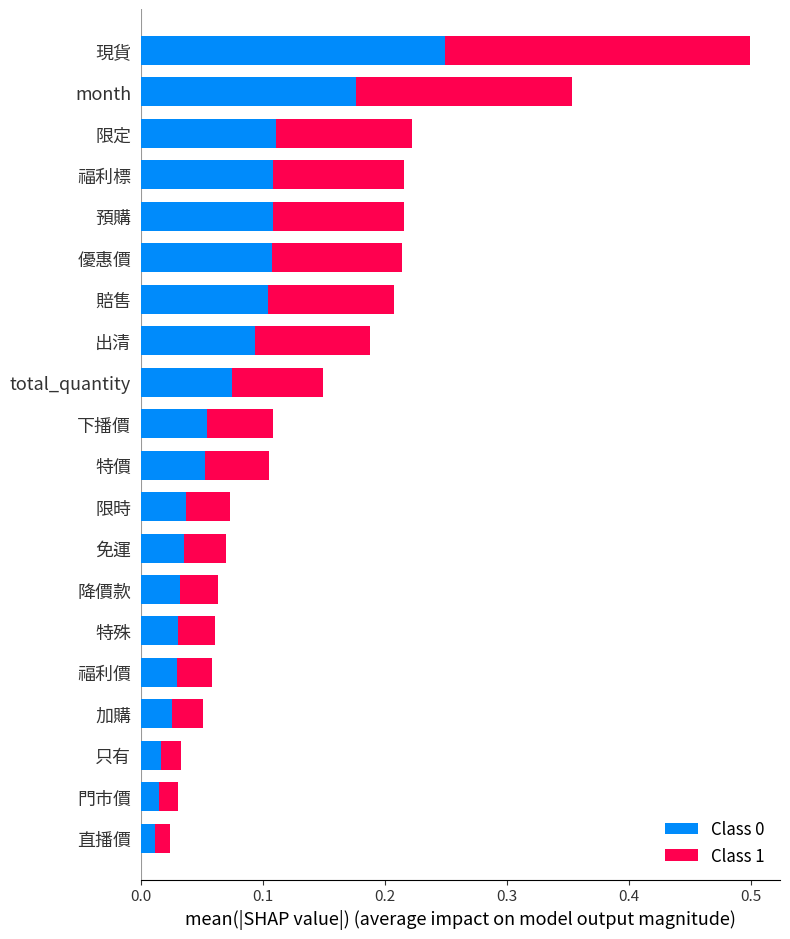

In [27]:
shap.initjs()

#label_item = ['Lower', 'Higher']

explainer_all = shap.TreeExplainer(bst)
shap_values_all = explainer_all.shap_values(features_all)

shap.summary_plot(shap_values_all, features_all)

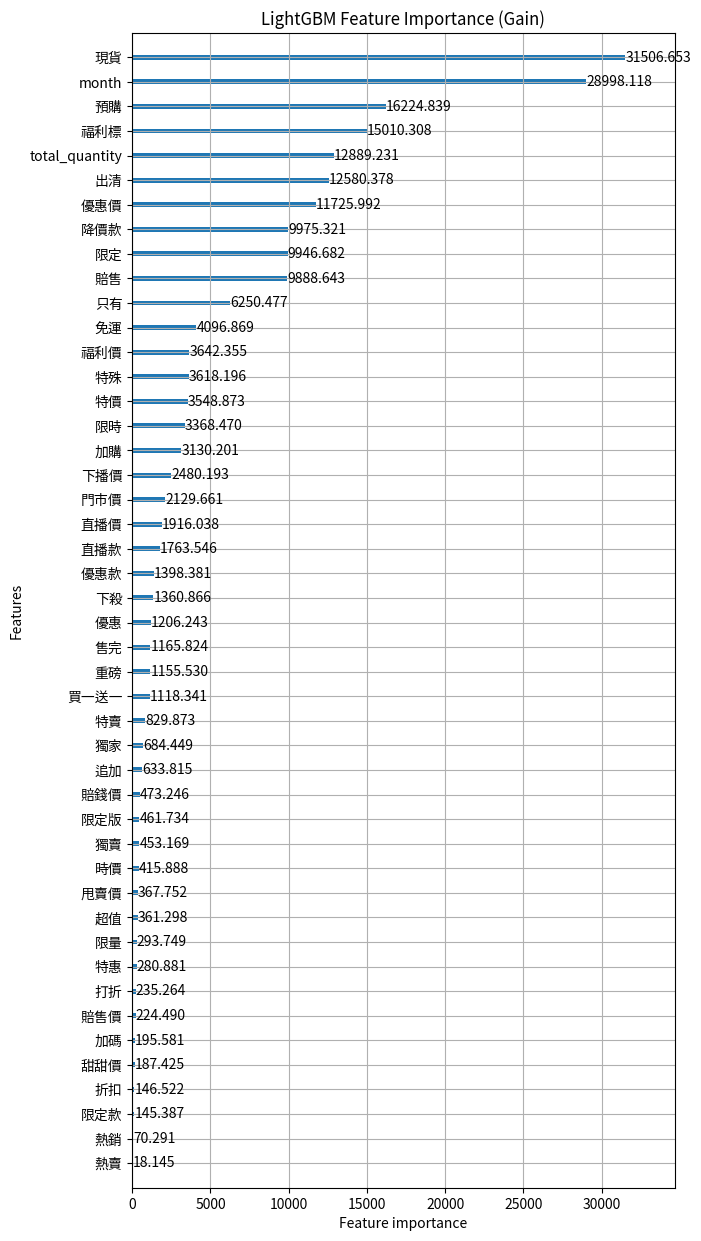

In [28]:
lgb.plot_importance(bst, importance_type="gain", figsize=(7,15), title="LightGBM Feature Importance (Gain)")
plt.show()

## 女性

In [35]:
female_data = pd.DataFrame()
for month in range(1, 13):
  female_data = pd.concat([female_data, female_clothing[f"{month:02d}"]], ignore_index=True)
female_data.sort_values(by=['time'], inplace=True)
female_data.loc[female_data['time'] == date(2021, 12, 31), 'time'] = date(2022, 1, 1)
female_data['time'] = pd.to_datetime(female_data['time'])
female_data.reset_index(drop=True, inplace=True)
# 只取價格大於等於0的資料
female_data = female_data[female_data['price'] >= 0]

In [36]:
# 製作針對商品名稱有無使用促銷詞、針對商品名稱有無使用Assertive促銷詞的特徵
female_data['Special'] = female_data['ProductName'].apply(lambda x: any(keyword in x for keyword in special_keywords))
female_data['Special'] = female_data['Special'].astype(int)
female_data['Assertive'] = female_data['ProductName'].apply(lambda x: any(keyword in x for keyword in assertive_words))
female_data['Assertive'] = female_data['Assertive'].astype(int)

In [37]:
for keyword in special_keywords:
    female_data[keyword] = female_data['ProductName'].str.contains(keyword, flags=re.IGNORECASE).astype(int)
female_data.fillna(0, inplace=True)

In [38]:
female_data.iloc[:, 12:]

,特價,現貨,預購,下播價,愛心價,直播價,福利價,優惠價,限定,重磅,...,獨賣,賠錢價,免運,回饋價,甩賣價,特惠,折扣,超限量,甜甜價,買一送一
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475805,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
475806,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
475807,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
475808,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 女性-有無使用促銷詞對銷售的影響

In [11]:
# 子類別平均單價
# 將類別總數 * 1/3 跟 2/3 來劃分區間
product_stats_f = female_data.groupby(['SubCategory']).agg({'price': 'mean'}).reset_index()
product_stats_f = product_stats_f.sort_values(by='price')
product_stats_f
# 33%: 428.214610 66%: 572.912515
# 低價位：內衣、內褲、哺乳內衣、絲襪、細肩帶/繞頸背心、其他、塑身衣、襪子、成套內衣褲、褲裙、緊身褲/內搭褲
# 中價位：吊帶褲/吊帶裙、長褲、裙裝、毛衣/針織、個人套裝、連身長褲、襯衫、其他外套、牛仔褲
# 高價位：斗篷、洋裝、背心外套、大學T、居家服、西裝、帽T、Polo衫、夾克、冬季外套/大衣、T恤、短褲

,SubCategory,price
3,內衣,243.328696
4,內褲,247.019367
9,哺乳內衣,287.680000
22,絲襪,299.442006
21,細肩帶/繞頸背心,315.186077
5,其他,343.400000
10,塑身衣,351.327072
27,襪子,389.712824
15,成套內衣褲,393.262162
26,褲裙,403.612159


### 低單價商品-有無使用促銷詞對銷售的影響

In [39]:
import statsmodels.api as sm

low_price = ['內衣', '內褲', '哺乳內衣', '絲襪', '細肩帶/繞頸背心', '其他', '塑身衣', '襪子', '成套內衣褲', '褲裙', '緊身褲/內搭褲']
# 將低價商品劃成同一群
low = female_data[female_data['SubCategory'].isin(low_price)]

# condition_low = (low.iloc[:, 12:59] == 0).all(axis=1)
# low = low[~condition_low]

test1 = low
#test2 = tshirt.groupby(['total_amount']).agg({'price': 'mean', 'total_quantity': 'mean','特價': 'sum',	'下殺價': 'sum',	'賠售': 'sum',	'限定': 'sum'	,'福利價': 'sum'	,'甜甜價': 'sum'	,'限量': 'sum'	,'優惠': 'sum'	,'折扣': 'sum', '回饋價': 'sum', '賠錢價': 'sum', '買一送一': 'sum', '只要': 'sum', '甩賣': 'sum', '下播價': 'sum', '包軌': 'sum', '愛心價': 'sum'}).reset_index()


# 添加截距列
test1['intercept'] = 1

# 自變數和因變數
X1 = test1[['intercept', 'total_quantity','price', 'Special']] #
y1 = test1['total_amount']

model1 = sm.OLS(y1, X1).fit()

yFit1 = model1.fittedvalues  # 模型擬合的 y 值
print(model1.summary())  # 輸出迴歸分析的摘要
print("\nOLS model: Y = b0 + b1*X + ... + bm*Xm")
print('Parameters: ', model1.params)

                            OLS Regression Results                            
Dep. Variable:           total_amount   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.452
Method:                 Least Squares   F-statistic:                 1.955e+04
Date:                Tue, 09 Jan 2024   Prob (F-statistic):               0.00
Time:                        17:01:03   Log-Likelihood:            -7.5911e+05
No. Observations:               70955   AIC:                         1.518e+06
Df Residuals:                   70951   BIC:                         1.518e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept        181.0472     46.492      3.

<ipython-input-39-6f4936d65c47>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test1['intercept'] = 1


### 中單價商品-有無使用促銷詞對銷售的影響

In [40]:
med_price = ['吊帶褲/吊帶裙', '長褲', '裙裝', '毛衣/針織', '個人套裝', '連身長褲', '襯衫', '其他外套', '牛仔褲']
# 將中價位商品劃成同一群
med = female_data[female_data['SubCategory'].isin(med_price)]

#condition_med = (med.iloc[:, 12:59] == 0).all(axis=1)
#med = med[~condition_med]

test2 = med
#test2 = tshirt.groupby(['total_amount']).agg({'price': 'mean', 'total_quantity': 'mean','特價': 'sum',	'下殺價': 'sum',	'賠售': 'sum',	'限定': 'sum'	,'福利價': 'sum'	,'甜甜價': 'sum'	,'限量': 'sum'	,'優惠': 'sum'	,'折扣': 'sum', '回饋價': 'sum', '賠錢價': 'sum', '買一送一': 'sum', '只要': 'sum', '甩賣': 'sum', '下播價': 'sum', '包軌': 'sum', '愛心價': 'sum'}).reset_index()


# 添加截距列
test2['intercept'] = 1

# 自變數和因變數
X2 = test2[['intercept', 'total_quantity','price', 'Special']] #
y2 = test2['total_amount']

model2 = sm.OLS(y2, X2).fit()

yFit2 = model2.fittedvalues  # 模型擬合的 y 值
print(model2.summary())  # 輸出迴歸分析的摘要
print("\nOLS model: Y = b0 + b1*X + ... + bm*Xm")
print('Parameters: ', model2.params)

                            OLS Regression Results                            
Dep. Variable:           total_amount   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                 1.200e+05
Date:                Tue, 09 Jan 2024   Prob (F-statistic):               0.00
Time:                        17:02:06   Log-Likelihood:            -1.7718e+06
No. Observations:              175509   AIC:                         3.544e+06
Df Residuals:                  175505   BIC:                         3.544e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept      -1156.7567     18.288    -63.

<ipython-input-40-bd803f3479a7>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test2['intercept'] = 1


### 高單價商品-有無使用促銷詞對銷售的影響

In [41]:
high_price = ['斗篷','洋裝','背心外套','大學T','居家服','西裝','帽T','Polo衫','夾克','冬季外套/大衣','T恤','短褲']
# 將高價位商品劃成同一群
high = female_data[female_data['SubCategory'].isin(high_price)]

#condition_high = (high.iloc[:, 12:59] == 0).all(axis=1)
#high = high[~condition_high]

test3 = high
#test2 = tshirt.groupby(['total_amount']).agg({'price': 'mean', 'total_quantity': 'mean','特價': 'sum',	'下殺價': 'sum',	'賠售': 'sum',	'限定': 'sum'	,'福利價': 'sum'	,'甜甜價': 'sum'	,'限量': 'sum'	,'優惠': 'sum'	,'折扣': 'sum', '回饋價': 'sum', '賠錢價': 'sum', '買一送一': 'sum', '只要': 'sum', '甩賣': 'sum', '下播價': 'sum', '包軌': 'sum', '愛心價': 'sum'}).reset_index()

# 添加截距列
test3['intercept'] = 1


# 自變數和因變數
X3 = test3[['intercept', 'total_quantity','price', 'Special']]
y3 = test3['total_amount']

model3 = sm.OLS(y3, X3).fit()

yFit3 = model3.fittedvalues  # 模型擬合的 y 值
print(model3.summary())  # 輸出迴歸分析的摘要
print("\nOLS model: Y = b0 + b1*X + ... + bm*Xm")
print('Parameters: ', model3.params)

<ipython-input-41-576a276fb792>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test3['intercept'] = 1


                            OLS Regression Results                            
Dep. Variable:           total_amount   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                 3.243e+06
Date:                Tue, 09 Jan 2024   Prob (F-statistic):               0.00
Time:                        17:02:55   Log-Likelihood:            -2.7697e+06
No. Observations:              229164   AIC:                         5.539e+06
Df Residuals:                  229160   BIC:                         5.540e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept         52.3476    100.965      0.

In [171]:
female_data

,id,time,commodity_id,category,ProductName,total_quantity,price,total_amount,new_Category,SubCategory,...,獨賣,賠錢價,免運,回饋價,甩賣價,特惠,折扣,超限量,甜甜價,買一送一
0,4043721,2021-12-31,5828350,['女生衣著'],三角造型扣羽絨棉背心特價不退,4,498,1992,女生衣著,背心外套,...,0,0,0,0,0,0,0,0,0,0
1,4044252,2021-12-31,5814868,['女生衣著'],妞第002標80189黑色牛仔褲可小一碼帶,2,330,660,女生衣著,牛仔褲,...,0,0,0,0,0,0,0,0,0,0
2,4044314,2021-12-31,5819833,['女生衣著'],妞第039標小可愛,1,199,199,女生衣著,細肩帶/繞頸背心,...,0,0,0,0,0,0,0,0,0,0
3,4043520,2021-12-31,5828286,['女生衣著'],螢光色羽絨棉背心特價不退,5,399,1995,女生衣著,背心外套,...,0,0,0,0,0,0,0,0,0,0
4,4044508,2021-12-31,5828576,['女生衣著'],第113標黑絨套裝1,1,190,190,女生衣著,個人套裝,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475805,21423581,2022-12-31,10719878,['女生衣著'],新04質感金蔥剪花玫瑰雪紡上衣,9,432,3888,女生衣著,T恤,...,0,0,0,0,0,0,0,0,0,0
475806,21423579,2022-12-31,10719877,['女生衣著'],2775紫色包心紗短洋,1,300,300,女生衣著,洋裝,...,0,0,0,0,0,0,0,0,0,0
475807,21423576,2022-12-31,10719874,['女生衣著'],第021標排扣款安格拉上衣,4,316,1264,女生衣著,T恤,...,0,0,0,0,0,0,0,0,0,0
475808,21423608,2022-12-31,10719889,['女生衣著'],第標超激瘦套裝,17,380,6460,女生衣著,個人套裝,...,0,0,0,0,0,0,0,0,0,0


### 整體-有無使用促銷詞對銷售的影響

In [42]:
test_all_f = female_data
#test2 = tshirt.groupby(['total_amount']).agg({'price': 'mean', 'total_quantity': 'mean','特價': 'sum',	'下殺價': 'sum',	'賠售': 'sum',	'限定': 'sum'	,'福利價': 'sum'	,'甜甜價': 'sum'	,'限量': 'sum'	,'優惠': 'sum'	,'折扣': 'sum', '回饋價': 'sum', '賠錢價': 'sum', '買一送一': 'sum', '只要': 'sum', '甩賣': 'sum', '下播價': 'sum', '包軌': 'sum', '愛心價': 'sum'}).reset_index()

# 添加截距列
test_all_f['intercept'] = 1


# 自變數和因變數
X_f = test_all_f[['intercept', 'total_quantity','price', 'Special']]
y_f = test_all_f['total_amount']

model_f = sm.OLS(y_f, X_f).fit()

yFit_f = model_f.fittedvalues  # 模型擬合的 y 值
print(model_f.summary())  # 輸出迴歸分析的摘要
print("\nOLS model: Y = b0 + b1*X + ... + bm*Xm")
print('Parameters: ', model_f.params)



yFit_f = model_f.fittedvalues  # 模型擬合的 y 值
print(model_f.summary())  # 輸出迴歸分析的摘要
print("\nOLS model: Y = b0 + b1*X + ... + bm*Xm")
print('Parameters: ', model_f.params)  # 輸出：擬合模型的係數
# 女性來說，有加特價關鍵字對於平均銷售額有顯著影響

                            OLS Regression Results                            
Dep. Variable:           total_amount   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                 6.439e+06
Date:                Tue, 09 Jan 2024   Prob (F-statistic):               0.00
Time:                        17:04:08   Log-Likelihood:            -5.5857e+06
No. Observations:              475628   AIC:                         1.117e+07
Df Residuals:                  475624   BIC:                         1.117e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept        824.1490     48.351     17.

## 女性-Assertive促銷詞對銷售的影響

In [43]:
female_data3 = female_data.copy()

# 將皆無使用促銷詞的過濾掉
condition3_f = (female_data3.iloc[:, 12:59] == 0).all(axis=1)
female_data3 = female_data3[~condition3_f]

test_promote_f = female_data3
#test2 = tshirt.groupby(['total_amount']).agg({'price': 'mean', 'total_quantity': 'mean','特價': 'sum',	'下殺價': 'sum',	'賠售': 'sum',	'限定': 'sum'	,'福利價': 'sum'	,'甜甜價': 'sum'	,'限量': 'sum'	,'優惠': 'sum'	,'折扣': 'sum', '回饋價': 'sum', '賠錢價': 'sum', '買一送一': 'sum', '只要': 'sum', '甩賣': 'sum', '下播價': 'sum', '包軌': 'sum', '愛心價': 'sum'}).reset_index()

# 添加截距列
test_promote_f['intercept'] = 1

# 自變數和因變數
X_promote_f = test_promote_f[['intercept', 'total_quantity','price', 'Assertive']] #
y_promote_f = test_promote_f['total_amount']

model_promote_f = sm.OLS(y_promote_f, X_promote_f).fit()

yFit_promote_f = model_promote_f.fittedvalues  # 模型擬合的 y 值
print(model_promote_f.summary())  # 輸出迴歸分析的摘要
print("\nOLS model: Y = b0 + b1*X + ... + bm*Xm")
print('Parameters: ', model_promote_f.params)

                            OLS Regression Results                            
Dep. Variable:           total_amount   R-squared:                       0.534
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                 1.326e+04
Date:                Tue, 09 Jan 2024   Prob (F-statistic):               0.00
Time:                        17:05:31   Log-Likelihood:            -3.6637e+05
No. Observations:               34748   AIC:                         7.327e+05
Df Residuals:                   34744   BIC:                         7.328e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept      -1999.3525    106.650    -18.

## 女性-價位區間與促銷詞的關係

In [44]:
female_price = female_data.copy()
female_price['month'] = female_data['time'].dt.month
# 去除離群值

# 計算價格欄位的平均值和標準差
mean_price_f = female_price['price'].mean()
std_price_f = female_price['price'].std()

# 定義一個閾值，價格超出平均值2倍標準差視為離群值
threshold_f = 2 * std_price_f

# 使用布林索引過濾離群值
female_price = female_price[(female_price['price'] >= (mean_price_f - threshold_f)) & (female_price['price'] <= (mean_price_f + threshold_f))]

# 重新設定索引
female_price.reset_index(drop=True, inplace=True)

price_dist_f = female_price['price'].describe()

In [52]:
condition_f = (female_price.iloc[:, 12:59] == 0).all(axis=1)
female_price = female_price[~condition_f]

In [53]:
bound_25_f = price_dist_f['25%']
bound_50_f = price_dist_f['50%']
bound_75_f = price_dist_f['75%']

# def assign_price_category(price, bound_25, bound_50, bound_75):
#     if price < bound_25:
#         return 1
#     elif price < bound_50:
#         return 2
#     elif price < bound_75:
#         return 3
#     else:
#         return 4

def assign_price_category(price, bound_25, bound_50, bound_75):
    res = 0
    if price < bound_25:
        res = 0
    elif price < bound_50:
        res = 1
    elif price < bound_75:
      res = 2
    else:
      res = 3
    if res == 0 or res == 1:
      return 0
    elif res == 2 or res == 3:
      return 1

female_price['price_category'] = female_price.apply(lambda row: assign_price_category(row['price'], bound_25_f, bound_50_f, bound_75_f), axis=1)

In [245]:
special_keywords

['特價',
 '現貨',
 '預購',
 '下播價',
 '愛心價',
 '直播價',
 '福利價',
 '優惠價',
 '限定',
 '重磅',
 '賠售',
 '獨家',
 '出清',
 '優惠',
 '時價',
 '限量',
 '售完',
 '直播款',
 '加購',
 '特賣',
 '特殊',
 '追加',
 '福利標',
 '限定版',
 '限時',
 '加碼',
 '賠售價',
 '限定款',
 '下殺',
 '門市價',
 '只有',
 '熱賣',
 '降價款',
 '熱銷',
 '優惠款',
 '打折',
 '超值',
 '獨賣',
 '賠錢價',
 '免運',
 '回饋價',
 '甩賣價',
 '特惠',
 '折扣',
 '超限量',
 '甜甜價',
 '買一送一']

In [54]:
features_all_f = female_price[['total_quantity', 'month', '特價',
 '現貨',
 '預購',
 '下播價',
 '愛心價',
 '直播價',
 '福利價',
 '優惠價',
 '限定',
 '重磅',
 '賠售',
 '獨家',
 '出清',
 '優惠',
 '時價',
 '限量',
 '售完',
 '直播款',
 '加購',
 '特賣',
 '特殊',
 '追加',
 '福利標',
 '限定版',
 '限時',
 '加碼',
 '賠售價',
 '限定款',
 '下殺',
 '門市價',
 '只有',
 '熱賣',
 '降價款',
 '熱銷',
 '優惠款',
 '打折',
 '超值',
 '獨賣',
 '賠錢價',
 '免運',
 '回饋價',
 '甩賣價',
 '特惠',
 '折扣',
 '超限量',
 '甜甜價',
 '買一送一']]
label_all_f = female_price['price_category']

In [55]:
X_train_all_f, X_test_all_f, y_train_all_f, y_test_all_f = train_test_split(features_all_f, label_all_f, test_size = 0.2, random_state = 0)

train_data_all_f = lgb.Dataset(X_train_all_f, label=y_train_all_f)
test_data_all_f = lgb.Dataset(X_test_all_f, label=y_test_all_f, reference=train_data_all_f)

params_all_f = {
    #'objective': 'multiclass',
    'objective': 'binary',
    #'num_class': 4,
    #'metric': 'multi_logloss',  # 多標籤分類的損失函數
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 50,
    'learning_rate': 0.01,
    'feature_fraction': 0.9,
    'max_bin': 255
}

num_round_f = 500
bst_f = lgb.train(params_all_f, train_data_all_f, num_round_f)

[LightGBM] [Info] Number of positive: 16563, number of negative: 11235
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 249
[LightGBM] [Info] Number of data points in the train set: 27798, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.595834 -> initscore=0.388137
[LightGBM] [Info] Start training from score 0.388137


In [56]:
# 進行預測
y_pred_proba_all_f = bst_f.predict(X_test_all_f, num_iteration=bst_f.best_iteration)
#y_pred_all_f = np.argmax(y_pred_proba_all_f, axis=1)  # 將機率轉換為預測的類別
y_pred_all_f = (y_pred_proba_all_f > np.mean(y_pred_proba_all_f)).astype(int)

In [57]:
from sklearn.metrics import accuracy_score
accuracy_all=accuracy_score(y_test_all_f, y_pred_all_f)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test_all_f, y_pred_all_f)))

LightGBM Model accuracy score: 0.7308


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


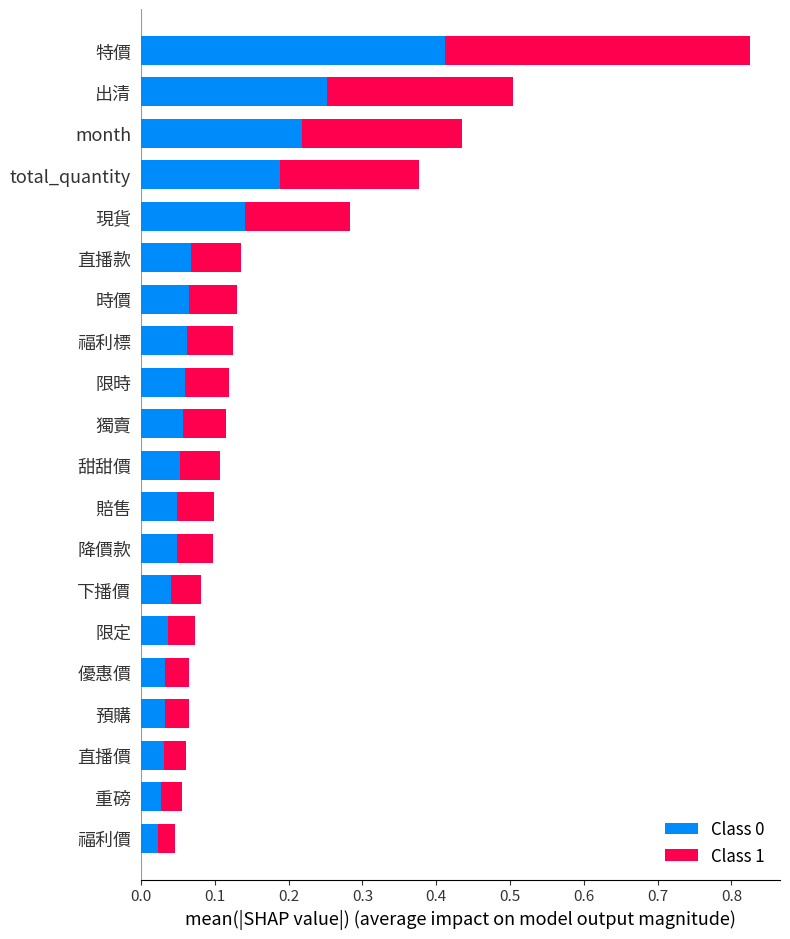

In [61]:
explainer_all_f = shap.TreeExplainer(bst_f)
shap_values_all_f = explainer_all_f.shap_values(features_all_f)

shap.summary_plot(shap_values_all_f, features_all_f)

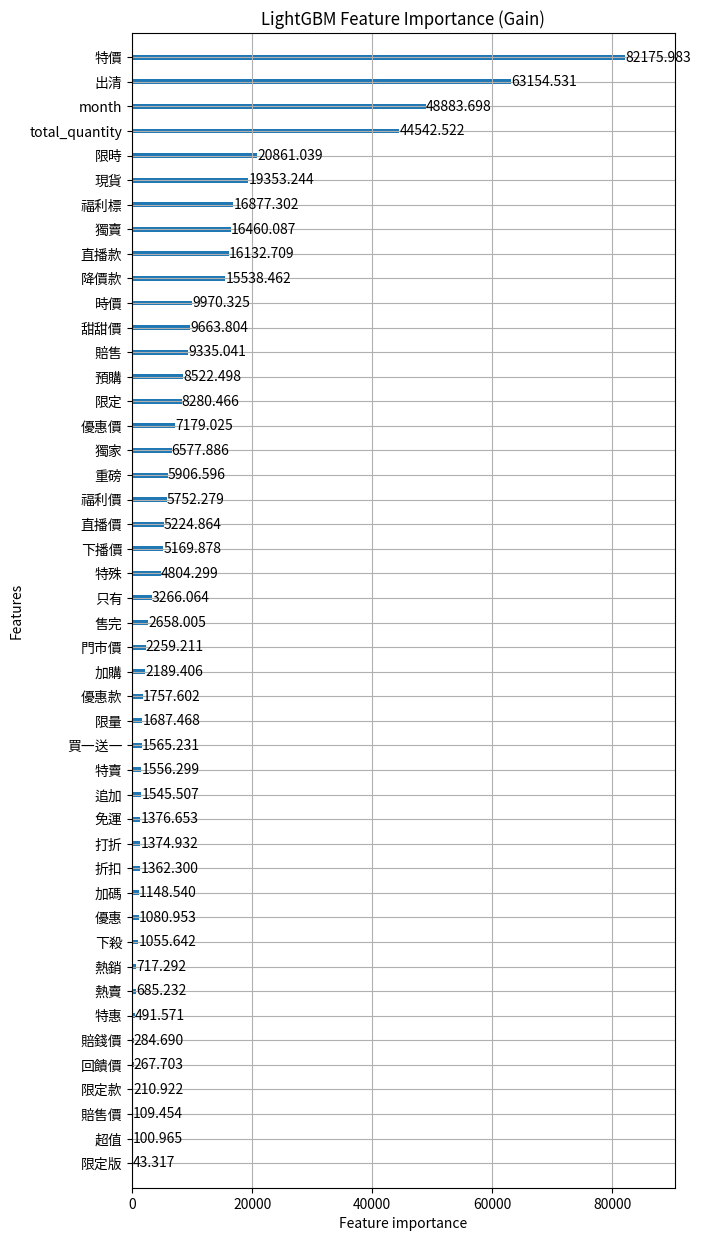

In [62]:
lgb.plot_importance(bst_f, importance_type="gain", figsize=(7,15), title="LightGBM Feature Importance (Gain)")
plt.show()